# **Modeling**

Using https://www.newscatcherapi.com/ as source for news data.

Target Models:
- Linear Regression Model 
- XGBoost Regressor
- Simple MLP
- HP-tuned Keras Neural Network
- Optimized Neural Network combining different Layers (FF, TC, LSTM, Transformer)
- Each for the next 12 Months and for the next 4 Quartals

Data Sets (always including oi history)
- OECD (Economic Indicators)
- OECD + SF (Salesforce Data)
- OECD + SF + SM (Stock Movements)
- OECD + SF + SM + GT (Google Trends)
- OECD + SF + SM + GT + News
- OECD + News

In [ ]:
#pip install --upgrade tensorflow==2.16.2

In [3]:
from modeling import *
from data_analysis import create_plot, color_palette

pio.renderers.default = "vscode"
# pio.renderers.default = "notebook_connected"

datasets = {}
models = {}
history = {}
evaluation = {}
model_save_path = 'Models'
os.makedirs(model_save_path, exist_ok=True)

datasets['OECD_original'] = load_preprocess_form_dataset(feature_files = ["../04 Data/OECD/Archiv/OECD_final.csv"], target_file = "../04 Data/HOMAG/OrderIntake_series_monthly.csv")
datasets['OECD'] = load_preprocess_form_dataset(feature_files = ["../04 Data/Integrated Datasets/OECD_integrated_01-16_11-24.csv"], target_file = "../04 Data/HOMAG/2024_12_16_OrderIntake_series_monthly_10y.csv")
datasets['OECD_SF'] = load_preprocess_form_dataset(feature_files = ["../04 Data/Integrated Datasets/OECD_SF_integrated_01-16_11-24.csv"], target_file = "../04 Data/HOMAG/2024_12_16_OrderIntake_series_monthly_10y.csv")
datasets['OECD_SF_SM'] = load_preprocess_form_dataset(feature_files = ["../04 Data/Integrated Datasets/OECD_SF_SM_integrated_01-16_11-24.csv"], target_file = "../04 Data/HOMAG/2024_12_16_OrderIntake_series_monthly_10y.csv")
datasets['OECD_SF_SM_GT'] = load_preprocess_form_dataset(feature_files = ["../04 Data/Integrated Datasets/OECD_SF_SM_GT_integrated_01-16_11-24.csv"], target_file = "../04 Data/HOMAG/2024_12_16_OrderIntake_series_monthly_10y.csv")
datasets['OECD_SF_SM_GT_Best_Predictors_10'] = load_preprocess_form_dataset(feature_files = ["../04 Data/Integrated Datasets/OECD_SF_SM_GT_integrated_best_predictors_01-16_11-24.csv"], target_file = "../04 Data/HOMAG/2024_12_16_OrderIntake_series_monthly_10y.csv")

Summary of null values in each column:
Month_1                        0
Month_2                        0
Month_3                        0
Month_4                        0
Month_5                        0
                              ..
OECD_STLABOUR_MUE_DNK          2
OECD_STLABOUR_MUE_EU27_2020    2
OECD_STLABOUR_MUE_POL          2
OECD_STLABOUR_MUE_SWE          3
OECD_STLABOUR_MUE_USA          1
Length: 166, dtype: int64
Dropped columns with 5 or more missing months:
Index(['OECD_MATERIAL_RESOURCES_DMC_AUT', 'OECD_MATERIAL_RESOURCES_DMC_DEU',
       'OECD_MATERIAL_RESOURCES_DMC_DNK', 'OECD_MATERIAL_RESOURCES_DMC_EA19',
       'OECD_MATERIAL_RESOURCES_DMC_EU27_2020',
       'OECD_MATERIAL_RESOURCES_DMC_POL', 'OECD_MATERIAL_RESOURCES_DMC_SWE',
       'OECD_MEI_REAL_PRC_SWE', 'OECD_MEI_REAL_PRI_AUT',
       'OECD_MEI_REAL_PRM_AUT'],
      dtype='object')
Shape of cleaned feature DataFrame: (78, 156)
Shape of aligned target DataFrame: (78, 8)
Summary of null values in each column:
Month

## **Model Training**

In [4]:
def LREnsemble_model_pipeline(dataset:Dataset, dataset_name):
    model, evaluation = build_train_evaluate_ensemble("linear", "LR Ensemble", dataset.X_train_multi_reshaped, dataset.y_train_multi, dataset.X_test_multi_reshaped, dataset.y_test_multi, dataset.dates_test_multi, dataset.target_scaler, feature_names=extended_features(dataset.time_series), dataset_name=dataset_name)
    return model, evaluation
def XGBEnsemble_model_pipeline(dataset:Dataset, dataset_name):
    model, evaluation = build_train_evaluate_ensemble("xgb", "XGB Ensemble", dataset.X_train_multi_reshaped, dataset.y_train_multi, dataset.X_test_multi_reshaped, dataset.y_test_multi, dataset.dates_test_multi, dataset.target_scaler, feature_names=extended_features(dataset.time_series), dataset_name=dataset_name)
    return model, evaluation
def MLPEnsemble_model_pipeline(dataset:Dataset, dataset_name):
    model, evaluation = build_train_evaluate_ensemble("mlp", "MLP Ensemble", 
                                                      np.concatenate((dataset.X_train_multi_reshaped, dataset.X_val_multi_reshaped), axis=0), 
                                                      np.concatenate((dataset.y_train_multi, dataset.y_val_multi), axis=0), 
                                                      dataset.X_test_multi_reshaped, dataset.y_test_multi, dataset.dates_test_multi, dataset.target_scaler, 
                                                      mlp_hyperparameters=MLP_hyperparameters(max_iter=10000),
                                                      dataset_name=dataset_name)
    return model, evaluation
def MLP_model_pipeline(dataset:Dataset, dataset_name):
    model, evaluation = train_and_evaluate_mlp_model(
                                    dataset.X_train_multi_reshaped, 
                                    dataset.y_train_multi, 
                                    dataset.X_val_multi_reshaped, 
                                    dataset.y_val_multi, 
                                    dataset.X_test_multi_reshaped, 
                                    dataset.y_test_multi, 
                                    dataset.dates_test_multi, 
                                    dataset.target_scaler,
                                    f"{dataset_name}_MLP",
                                    dataset_name,
                                    hyperparameters=MLP_hyperparameters()
                                ) 
    return model, evaluation
def MLPgs_model_pipeline(dataset:Dataset, dataset_name):
    model, evaluation = train_and_evaluate_mlp_with_grid_search(
                                    dataset.X_train_multi_reshaped, dataset.y_train_multi, 
                                    dataset.X_val_multi_reshaped, dataset.y_val_multi, 
                                    dataset.X_test_multi_reshaped, dataset.y_test_multi, 
                                    dataset.dates_test_multi, 
                                    dataset.target_scaler,
                                    f"{dataset_name}_MLP_gs",
                                    dataset_name
                                )   
    return model, evaluation
def FCNN_model_pipeline(dataset:Dataset, dataset_name):
    model, history, evaluation = build_train_evaluate_fcnn_model(  
                                    dataset.X_train_multi, dataset.y_train_multi, 
                                    dataset.X_val_multi, dataset.y_val_multi, 
                                    X_test=dataset.X_test_multi, y_test=dataset.y_test_multi, dates=dataset.dates_test_multi,
                                    scaler=dataset.target_scaler,
                                    dataset_name=dataset_name,
                                    hyperparameters=FCNN_hyperparameters(batch_size=dataset.X_train_multi.shape[0], epochs=250, initial_lr=0.008,lr_decay_rate=0.4, lr_decay_step=150, dynamic_batch_decay_epoch=150, dynamic_batch_decay_factor=int(dataset.X_train_multi.shape[0]/3))
                                )   
    return model, history, evaluation
def NN_model_pipeline(dataset:Dataset, dataset_name):
    model, history, evaluation = build_train_evaluate_nn(
                                    dataset.X_train_multi, dataset.y_train_multi, 
                                    dataset.X_val_multi, dataset.y_val_multi, 
                                    dataset.X_test_multi, dataset.y_test_multi, 
                                    dataset.dates_test_multi, dataset.target_scaler,
                                    dataset_name=dataset_name,
                                    hyperparameters=NN_hyperparameters(epochs=150, initial_batch_size=dataset.X_train_multi.shape[0],batch_size_decay_factor=0.5, batch_size_decay_step=100, initial_lr=0.01, lr_decay_rate=0.4, lr_decay_step=100)
                                )
    return model, history, evaluation

def training_pipeline(dataset:Dataset, dataset_name, models_to_train=["lr", "xgb", "mlp_ensemble", "mlp", "mlp_gs", "fcnn", "nn"]):
    models = {}
    evaluation = {}
    history = {}
    # Linear Regression Ensemble
    if "lr" in models_to_train:
        models["LR Ensemble"], evaluation["LR Ensemble"] = LREnsemble_model_pipeline(dataset, dataset_name)
    # XGB Regressor Ensemble
    if "xgb" in models_to_train:
        models["XGB Ensemble"], evaluation["XGB Ensemble"] = XGBEnsemble_model_pipeline(dataset, dataset_name)
    # MLP Ensemble
    if "mlp_ensemble" in models_to_train:
        models["MLP Ensemble"], evaluation["MLP Ensemble"] = MLPEnsemble_model_pipeline(dataset, dataset_name)
    # MLP
    if "mlp" in models_to_train:
        models["MLP"], evaluation["MLP"] = MLP_model_pipeline(dataset, dataset_name)
    # MLP with Grid Search
    if "mlp_gs" in models_to_train:
        models["MLP GS"], evaluation["MLP GS"] = MLPgs_model_pipeline(dataset, dataset_name)
    # Fully Connected Neural Network (FCNN)
    if "fcnn" in models_to_train:
        models["FCNN"], history["FCNN"], evaluation["FCNN"] = FCNN_model_pipeline(dataset, dataset_name)
    # Neural Network using FF, TCN, LSTM and Transformer-Encoder
    if "nn" in models_to_train:
        models["NN"], history["NN"], evaluation["NN"] = NN_model_pipeline(dataset, dataset_name)
    return models, history, evaluation
def summarize_training_run(evaluations, histories):
    evaluations_dfs =[]
    for dataset, model_evaluations_dict in evaluations.items():
        for model, eval_df in model_evaluations_dict.items():
            df = eval_df.copy()
            df["Dataset"] = dataset
            evaluations_dfs.append(df)
    experiment_results_overview_df = pd.concat(evaluations_dfs, ignore_index=True)
    experiment_results_overview_df.set_index(["Dataset", "Model"], inplace=True)

    experiment_results = {
        "Models": models,
        "Histories": histories, # contains the learning rate, loss, val_loss, mae and val_mae over the training epochs
        "Evaluations": experiment_results_overview_df, # contains the target metrics for each combination of dataset and model to select the best
    }
    return experiment_results

current_dataset = "OECD_SF_SM_GT"
data = Dataset(datasets[current_dataset])
print(f"{current_dataset}:", data.X_multi.shape, min(data.dates_multi), "to", max(data.dates_multi))
print("Features:", data.feature_df.shape, min(data.feature_df.index), "to", max(data.feature_df.index))
print("Target:", data.target_df.shape, min(data.target_df.index), "to", max(data.target_df.index))

OECD_SF_SM_GT: (84, 12, 234) 2017-01-01 00:00:00 to 2023-12-01 00:00:00
Features: (108, 233) 2016-01-01 00:00:00 to 2024-12-01 00:00:00
Target: (203, 8) 2008-01-01 00:00:00 to 2024-11-01 00:00:00


In [ ]:
models = {}
histories = {}
evaluations = {}

for i in range(1): # To train the models multiple times if intended
    for dataset_name, data in datasets.items():
        if dataset_name in ["OECD", "OECD_SF", "OECD_SF_SM", "OECD_SF_SM_GT"]: #["OECD_original", "OECD", "OECD_SF", "OECD_SF_SM", "OECD_SF_SM_GT"]
            print(dataset_name)
            models[dataset_name], histories[dataset_name], evaluations[dataset_name] = training_pipeline(data, dataset_name, models_to_train=["fcnn"]) # models_to_train=["lr", "xgb", "mlp_ensemble", "mlp", "mlp_gs", "fcnn", "nn"]

summary = summarize_training_run(evaluations, histories)

In [8]:
display(summary["Evaluations"])

MSE (scaled)   MAE (M€)  \
Dataset       Model                                                  
OECD          OECD_FCNN Archived               0.111346  20.700124   
              OECD_FCNN                        0.110042  21.100148   
OECD_SF       OECD_SF_FCNN Archived            0.108774  21.924532   
              OECD_SF_FCNN                     0.111693  20.516415   
OECD_SF_SM    OECD_SF_SM_FCNN Archived         0.109290  21.906327   
              OECD_SF_SM_FCNN                  0.114422  24.684547   
OECD_SF_SM_GT OECD_SF_SM_GT_FCNN Archived      0.112526  24.094757   
              OECD_SF_SM_GT_FCNN               0.115066  24.930928   

                                           R² Score (%)  \
Dataset       Model                                       
OECD          OECD_FCNN Archived              -2.677788   
              OECD_FCNN                       -1.475067   
OECD_SF       OECD_SF_FCNN Archived           -0.305802   
              OECD_SF_FCNN                    -2.997368   
OECD_SF_SM    OECD_SF_SM_FCNN Archived        -0.781701   
              OECD_SF_SM_FCNN                 -5.514248   
OECD_SF_SM_GT OECD_SF_SM_GT_FCNN Archived     -3.765263   
              OECD_SF_SM_GT_FCNN              -6.108273   

                                           Explained Variance (%)  
Dataset       Model                                                
OECD          OECD_FCNN Archived                        -0.131901  
              OECD_FCNN                                  0.094852  
OECD_SF       OECD_SF_FCNN Archived                      0.040508  
              OECD_SF_FCNN                               0.137899  
OECD_SF_SM    OECD_SF_SM_FCNN Archived                  -0.011277  
              OECD_SF_SM_FCNN                            0.148198  
OECD_SF_SM_GT OECD_SF_SM_GT_FCNN Archived               -0.137316  
              OECD_SF_SM_GT_FCNN                         0.107692

## **Evaluation**

#### Evaluate and compare models on test dataset

In [ ]:
def evaluate_and_compare(datasets):
    model_comparisons = pd.DataFrame()

    for dataset, data in datasets.items():
        data = Dataset(data)
        
        model_paths_multi_sklearn = {
            "MLP_multi": os.path.join("Model Archive", f"{dataset}_MLP.pkl"),
            "MLP_gs": os.path.join("Model Archive", f"{dataset}_MLP_gs.pkl")
        }
        models_multi_sklearn = {}
        for model_name in model_paths_multi_sklearn.keys():
            models_multi_sklearn[model_name] = load_model(model_paths_multi_sklearn[model_name])

        model_paths_multi_keras = {
            "FCNN": os.path.join("Model Archive", f"{dataset}_FCNN.keras"),
            "NN": os.path.join("Model Archive", f"{dataset}_NN.keras")
        }
        models_multi_keras = {}
        for model_name in model_paths_multi_keras.keys():
            models_multi_keras[model_name] = keras_load_model(model_paths_multi_keras[model_name]) 

        lr = MultivariateEnsemble("linear", model_name="LR Ensemble", dataset_name=dataset)
        lr.fit(np.concatenate((data.X_train_multi_reshaped, data.X_val_multi_reshaped), axis=0), np.concatenate((data.y_train_multi, data.y_val_multi), axis=0))
        xgb = MultivariateEnsemble("xgb", model_name="XGB Ensemble", dataset_name=dataset)
        xgb.fit(np.concatenate((data.X_train_multi_reshaped, data.X_val_multi_reshaped), axis=0), np.concatenate((data.y_train_multi, data.y_val_multi), axis=0))
        mlp = MultivariateEnsemble("mlp", model_name="MLP Ensemble", dataset_name=dataset)
        mlp.load()
        models_ensembles = {
            "LR Ensemble": lr,
            "XGB Ensemble": xgb,
            "MLP Ensemble": mlp
        }
        
        model_comparison_multi_sklearn, _ = compare_evaluations(models_multi_sklearn, data.X_test_multi_reshaped, data.y_test_multi, data.dates_test_multi, data.target_scaler)
        model_comparison_multi_keras, _ = compare_evaluations(models_multi_keras, data.X_test_multi, data.y_test_multi, data.dates_test_multi, data.target_scaler)
        model_comparison_multi_ensembles, _ = compare_evaluations(models_ensembles, data.X_test_multi_reshaped, data.y_test_multi, data.dates_test_multi, data.target_scaler)
        
        model_comparison_multi_sklearn["Dataset"] = dataset
        model_comparison_multi_keras["Dataset"] = dataset
        model_comparison_multi_ensembles["Dataset"] = dataset
        model_comparisons_multi = [model_comparison_multi_sklearn, model_comparison_multi_keras, model_comparison_multi_ensembles]
        
        model_comparison = pd.concat(model_comparisons_multi, ignore_index=True)  

        model_comparisons = pd.concat([model_comparisons, model_comparison], ignore_index=True) 
    
    model_comparisons = model_comparisons[["Dataset"] + model_comparisons.columns.drop(["Dataset"]).tolist()]

    model_comparisons.set_index(["Dataset", "Model"], inplace=True)

    save_results_to_excel({"Model Comparison": model_comparisons}, "Model_Comparison_Results.xlsx")

    return model_comparisons

model_comparison = evaluate_and_compare(datasets)

In [19]:
model_comparison.info()
display(model_comparison.sort_values(by="MAE (M€)", ascending=True))

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 35 entries, ('OECD_original', 'MLP_multi') to ('OECD_SF_SM_GT', 'MLP Ensemble')
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   MSE (scaled)            35 non-null     float64
 1   MAE (M€)                35 non-null     float64
 2   R² Score (%)            35 non-null     float64
 3   Explained Variance (%)  35 non-null     float64
dtypes: float64(4)
memory usage: 1.8+ KB


MSE (scaled)   MAE (M€)  R² Score (%)  \
Dataset       Model                                                 
OECD_original NN                0.090618  18.655085     -8.969048   
              FCNN              0.087082  18.915399     -4.717877   
              MLP_multi         0.096610  20.101985    -16.174658   
OECD_SF_SM_GT FCNN              0.124811  20.131097     -7.763506   
OECD_SF       FCNN              0.125511  20.356407     -8.368059   
              NN                0.127968  20.933380    -10.489223   
OECD          FCNN              0.118051  22.022066     -1.927239   
OECD_SF_SM_GT NN                0.155776  22.587125    -34.499587   
OECD_SF_SM    NN                0.151639  22.819226    -30.927240   
OECD_SF_SM_GT MLP_gs            0.141171  22.928031    -21.889502   
OECD_SF_SM    MLP_gs            0.141171  22.928031    -21.889502   
              FCNN              0.119648  23.401150     -3.306208   
OECD_original MLP_gs            0.152535  23.596204    -83.426101   
OECD_SF_SM_GT LR Ensemble       0.177932  26.711389    -53.629181   
OECD_SF_SM    LR Ensemble       0.177932  26.711389    -53.629181   
OECD_SF       LR Ensemble       0.177321  26.825299    -53.101710   
OECD_original XGB Ensemble      0.164502  26.854944    -97.816206   
OECD          MLP_gs            0.192287  27.162745    -66.023212   
              LR Ensemble       0.186428  27.727870    -60.965045   
OECD_original MLP Ensemble      0.164567  28.253145    -97.893842   
OECD_SF       MLP Ensemble      0.190320  28.565367    -64.325231   
OECD_SF_SM    MLP Ensemble      0.184306  28.971976    -59.132307   
OECD          MLP_multi         0.190825  29.573896    -64.761093   
OECD_SF_SM_GT MLP Ensemble      0.183777  29.583829    -58.676007   
OECD          MLP Ensemble      0.209205  29.694797    -80.630374   
OECD_SF       MLP_gs            0.210585  29.956843    -81.822080   
OECD_original LR Ensemble       0.200201  30.534348   -140.744457   
OECD_SF       MLP_multi         0.215736  31.723638    -86.269770   
OECD          NN                0.250980  32.209582   -116.700083   
OECD_SF       XGB Ensemble      0.218027  33.338282    -88.248110   
OECD_SF_SM_GT XGB Ensemble      0.220144  33.445974    -90.075694   
OECD_SF_SM    XGB Ensemble      0.220144  33.445974    -90.075694   
OECD          XGB Ensemble      0.231943  34.193247   -100.263506   
OECD_SF_SM_GT MLP_multi         0.260284  34.514220   -124.732785   
OECD_SF_SM    MLP_multi         0.263988  37.830362   -127.931659   

                            Explained Variance (%)  
Dataset       Model                                 
OECD_original NN                         -1.609303  
              FCNN                       -1.661749  
              MLP_multi                  -4.714471  
OECD_SF_SM_GT FCNN                       -0.104398  
OECD_SF       FCNN                       -0.344194  
              NN                         -0.816024  
OECD          FCNN                       -0.502167  
OECD_SF_SM_GT NN                         -2.545765  
OECD_SF_SM    NN                          0.892595  
OECD_SF_SM_GT MLP_gs                    -10.006528  
OECD_SF_SM    MLP_gs                    -10.006528  
              FCNN                       -0.538147  
OECD_original MLP_gs                    -23.508570  
OECD_SF_SM_GT LR Ensemble               -11.791923  
OECD_SF_SM    LR Ensemble               -11.791923  
OECD_SF       LR Ensemble                -4.684961  
OECD_original XGB Ensemble             -106.682454  
OECD          MLP_gs                    -11.063601  
              LR Ensemble                -9.040054  
OECD_original MLP Ensemble              -50.050625  
OECD_SF       MLP Ensemble               -8.618069  
OECD_SF_SM    MLP Ensemble              -13.690522  
OECD          MLP_multi                 -12.221328  
OECD_SF_SM_GT MLP Ensemble              -19.777639  
OECD          MLP Ensemble              -15.524341  
OECD_SF       MLP_gs                     -1

#### Evaluate best model: Present predictions vs. true values on 5 year time period, error distribution, error residuals

In [ ]:
data = Dataset(datasets["OECD_original"])

e = evaluate_model_multi_target(keras_load_model(os.path.join("Model Archive V1", f"OECD_NN.keras")), data.X_multi, data.y_multi, data.dates_multi, data.target_scaler, model_name='NN', feature_names=data.time_series, plotly=True)
display(e)

In [ ]:
data = Dataset(datasets["OECD_original"])
evaluate_model_multi_target(keras_load_model(os.path.join("Model Archive V1", f"OECD_FFNN.keras")), data.X_multi, data.y_multi, data.dates_multi, data.target_scaler, model_name='FCNN', feature_names=data.time_series)

In [ ]:
data = Dataset(datasets["OECD_SF_SM_GT"])

e = evaluate_model_multi_target(keras_load_model(os.path.join("Model Archive", f"OECD_SF_SM_GT_FCNN.keras")), data.X_multi, data.y_multi, data.dates_multi, data.target_scaler, model_name='FCNN', plotly=True)#, feature_names=time_series)
display(e)

In [ ]:
data = Dataset(datasets["OECD_SF_SM_GT"])

e = evaluate_model_multi_target(keras_load_model(os.path.join("Model Archive", f"OECD_SF_SM_GT_NN.keras")), data.X_multi, data.y_multi, data.dates_multi, data.target_scaler, model_name='NN', plotly=True)#, feature_names=time_series
display(e)

## **Prediction**
Select best data basis and best model to predict sales

In [ ]:
best_dataset_name = "OECD_SF_SM_GT"
predictions_report_filename = "sales_predictions_11-24_from_12-24_to_11-25.xlsx"

predictions_df, prediction_plot, prediction_plot_imgstream = prediction_report(dataset_name=best_dataset_name, dataset=Dataset(datasets[best_dataset_name]), filename=predictions_report_filename)

display(predictions_df)
prediction_plot.show()

c:\Users\tb10muj\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.

c:\Users\tb10muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning:

The structure of `inputs` doesn't match the expected structure: input_layer_5. Received: the structure of inputs=['*']



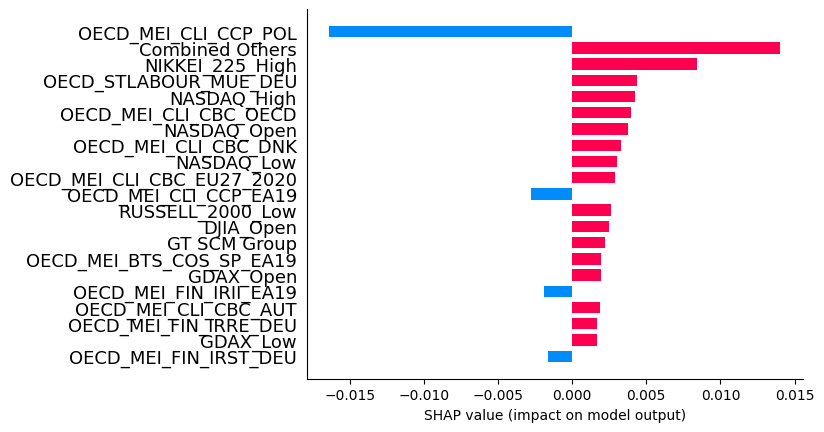

In [3]:
# Explain predictions of best model
dataset_name = "OECD_SF_SM_GT"
best_model_name = f"{dataset_name}_NN"
model = keras_load_model(os.path.join("Model Archive", f"{best_model_name}.keras"))
dataset = Dataset(datasets[dataset_name])

explain_latest_prediction(model, dataset, top_n=20, extend_features=False)

c:\Users\tb10muj\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.

c:\Users\tb10muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning:

The structure of `inputs` doesn't match the expected structure: input_layer_4. Received: the structure of inputs=['*']



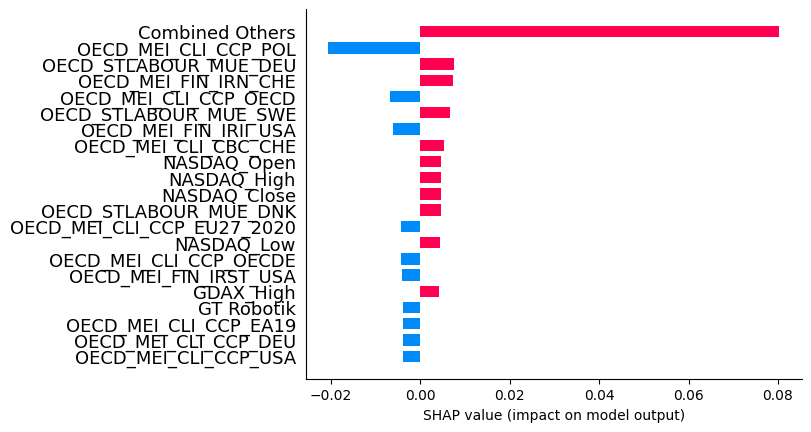

In [4]:
# Explain predictions of best model
dataset_name = "OECD_SF_SM_GT"
best_model_name = f"{dataset_name}_FCNN"
model = keras_load_model(os.path.join("Model Archive", f"{best_model_name}.keras"))
dataset = Dataset(datasets[dataset_name])

explain_latest_prediction(model, dataset, top_n=20, extend_features=False)

## **Model Explanation**
- Welche Features beeinflussen den Auftragseingang durchschnittlich am stärksten?
- Welche Features tragen am meisten zum aktuellen Wert des Auftragseingangs bei?
- Welche Änderungen in beeinflussbaren Variablen würden den AE verbessern?

c:\Users\tb10muj\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.

c:\Users\tb10muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning:

The structure of `inputs` doesn't match the expected structure: input_layer_4. Received: the structure of inputs=['*']



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


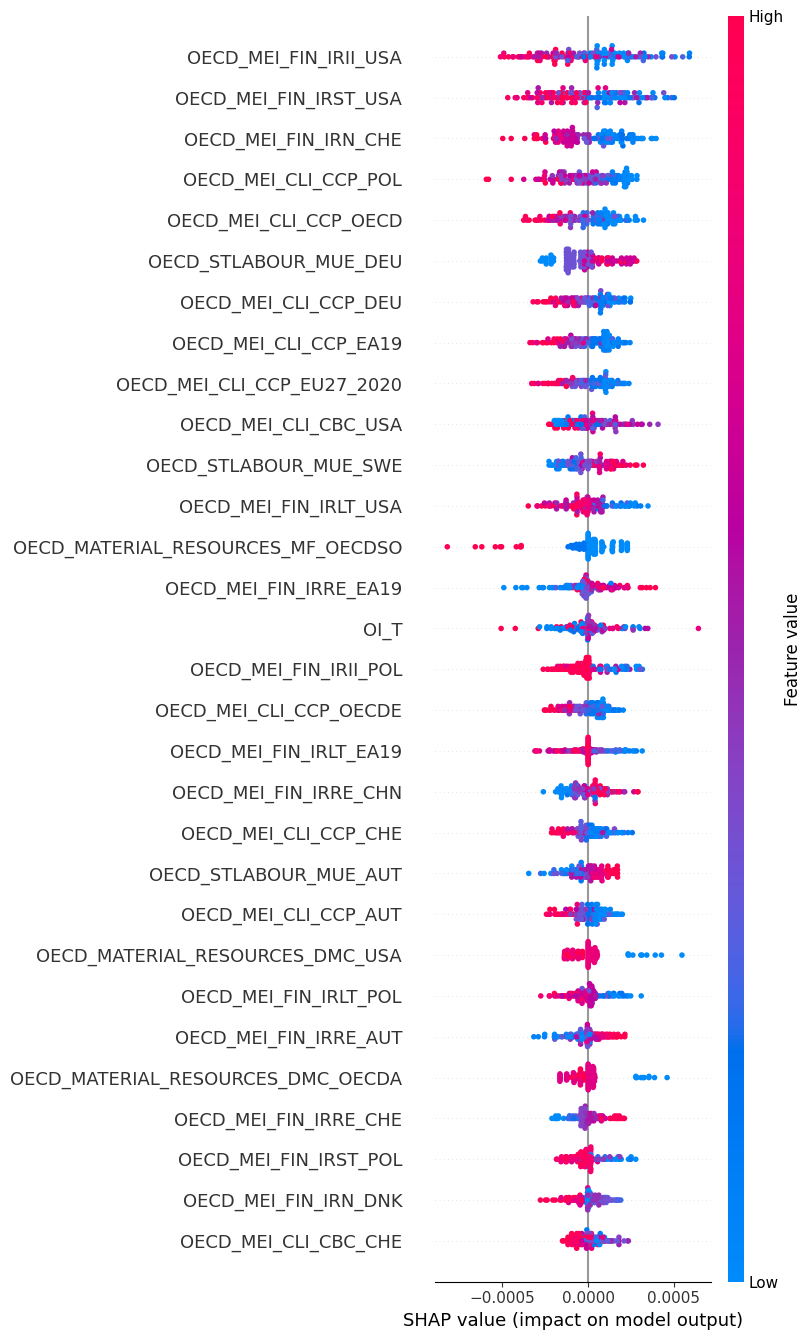

None

In [ ]:
dataset = Dataset(datasets["OECD_original"])
model = keras_load_model(os.path.join("Model Archive V1", f"OECD_FFNN.keras"))

explain_model(model, dataset, summary_output_index=3)

c:\Users\tb10muj\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.

c:\Users\tb10muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning:

The structure of `inputs` doesn't match the expected structure: input_layer_4. Received: the structure of inputs=['*']



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


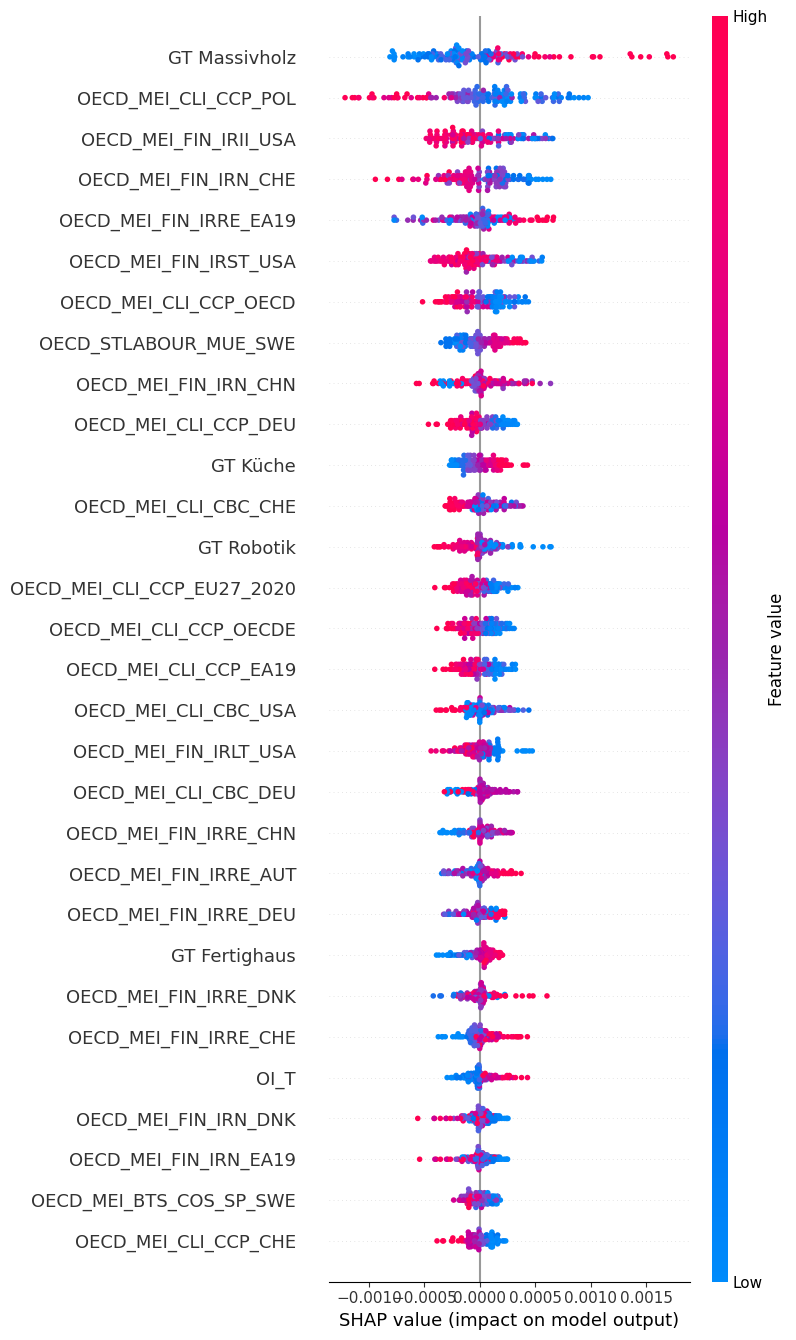

In [4]:
dataset_name = "OECD_SF_SM_GT"
model_name = f"{dataset_name}_FCNN"
dataset = Dataset(datasets[dataset_name])
model = keras_load_model(os.path.join("Model Archive", f"{model_name}.keras"))

explain_model(model, dataset, summary_output_index=3)